In [2]:
# Core Libraries
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis

# Data Vizualiation
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization

### Phase 1: Project Setup & Data Exploration

In [4]:
#load data
df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Financial Market A-B Testing\financial_market_ab_test.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ticker            1000 non-null   object 
 1   date              1000 non-null   object 
 2   price_before      1000 non-null   float64
 3   price_after       1000 non-null   float64
 4   volume_before     1000 non-null   int64  
 5   volume_after      1000 non-null   int64  
 6   strategy_version  1000 non-null   object 
 7   market_condition  1000 non-null   object 
 8   return_before     1000 non-null   float64
 9   return_after      1000 non-null   float64
 10  target            1000 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 86.1+ KB


In [5]:
# Summary statistics
print(df.describe())

       price_before  price_after  volume_before   volume_after  return_before  \
count   1000.000000  1000.000000    1000.000000    1000.000000    1000.000000   
mean    1050.464151  1046.948389  496237.225000  517045.527000      -0.002686   
std      556.165184   548.718460  284876.038329  282563.076918       0.058713   
min      108.800844   100.255917    3187.000000    1917.000000      -0.099850   
25%      547.826899   593.646942  265193.750000  275485.250000      -0.053926   
50%     1058.272542  1048.723987  484448.500000  502749.000000      -0.004915   
75%     1515.583885  1527.331884  743872.000000  770801.000000       0.048517   
max     1998.886079  1996.860272  999555.000000  998159.000000       0.099810   

       return_after       target  
count   1000.000000  1000.000000  
mean       0.000257     0.002943  
std        0.056566     0.082762  
min       -0.099874    -0.199067  
25%       -0.046760    -0.056335  
50%        0.001758     0.004636  
75%        0.046966     0

#### Step 1.3: Data Cleaning & Preprocessing

In [6]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])


In [7]:
# Check for duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")


Duplicate rows: 0


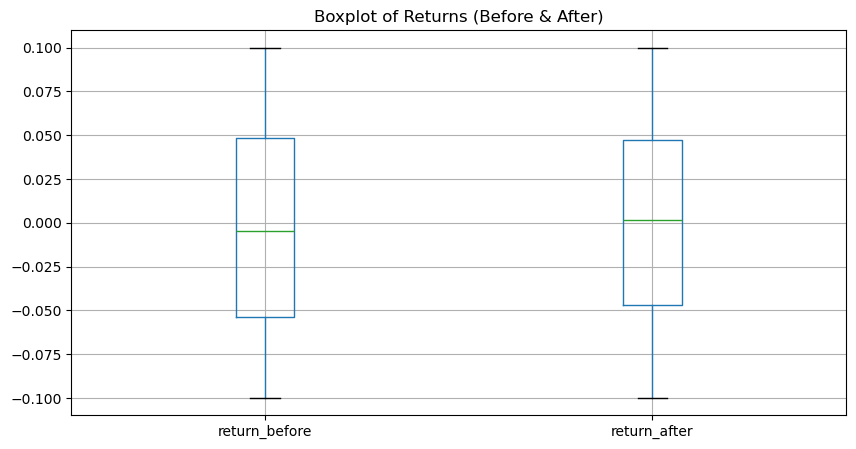

In [8]:
import matplotlib.pyplot as plt

# Box plot for return_before and return_after
plt.figure(figsize=(10, 5))
df[['return_before', 'return_after']].boxplot()
plt.title("Boxplot of Returns (Before & After)")
plt.show()


### Phase 2 - Exploratory Data Analysis (EDA)

#### Step 2.1: Compare Control vs. Treatment Group

In [9]:
# Unique strategy versions
print(df['strategy_version'].value_counts())


strategy_version
B    517
A    483
Name: count, dtype: int64


#### No information provided on A and B let's identify which is Control vs Treatment group

In [10]:
# Compare average return_before between the two strategy versions
print(df.groupby('strategy_version')['return_before'].mean())


strategy_version
A    0.000035
B   -0.005228
Name: return_before, dtype: float64


##### Strategy A (return_before ≈ 0.000035) → This suggests a stable or baseline performance, which is characteristic of a Control group.
##### Strategy B (return_before ≈ -0.005228) This suggests a negative average return before intervention, meaning it could be an experimental strategy (Treatment group).

In [12]:
# Calculate the profit difference
df['profit_difference'] = df['return_after'] - df['return_before']

# Group by strategy and calculate mean profit difference
profit_by_strategy = df.groupby('strategy_version')['profit_difference'].mean()

# Display results
print(profit_by_strategy)


strategy_version
A   -0.003031
B    0.008523
Name: profit_difference, dtype: float64


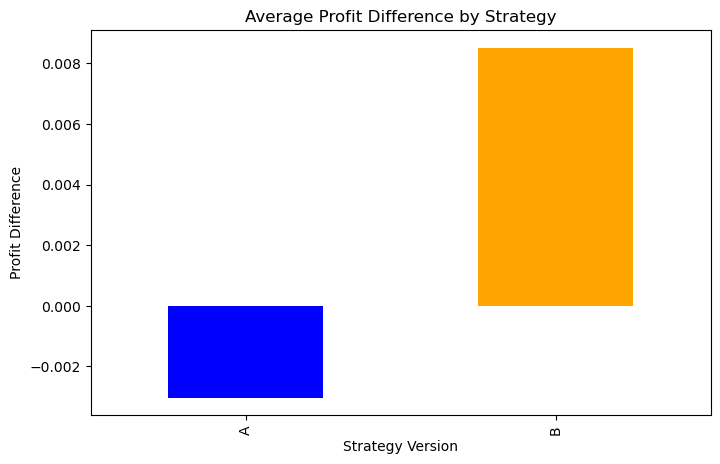

In [13]:
import matplotlib.pyplot as plt

# Plot bar chart
profit_by_strategy.plot(kind='bar', figsize=(8, 5), color=['blue', 'orange'])
plt.title("Average Profit Difference by Strategy")
plt.ylabel("Profit Difference")
plt.xlabel("Strategy Version")
plt.show()


### Phase 3: Statistical A/B Testing

#### 3.1 Define Hypothesis for A/B Testing: Let's set up t-test

##### Null Hypothesis (H₀): There is no significant difference in profit improvement between Strategy A and Strategy B.
##### Alternative Hypothesis (H₁): Strategy B has a significantly higher profit improvement than Strategy A.

#### 3.2 Conduct an Independent T-Test

In [14]:
from scipy import stats

# Extract profit differences for both groups
profit_A = df[df['strategy_version'] == 'A']['profit_difference']
profit_B = df[df['strategy_version'] == 'B']['profit_difference']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(profit_A, profit_B, equal_var=False)  # Welch’s t-test

# Print results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


T-Statistic: -2.2098
P-Value: 0.0273


##### The p-value tells us if we can reject the null hypothesis:
##### p < 0.05 → Strategy B’s improvement is statistically significant.
##### p ≥ 0.05 → The difference may be random variation.

##### Conclusion: Strategy B (treatment group) significantly outperforms Strategy A (control group).
##### There is strong statistical evidence that Strategy B improves profitability.

#### 3.3 - External Variable Analysis: let's check if market conditions (or other external factors) influenced profitability.

In [15]:
# Group profit difference by market condition
profit_by_market = df.groupby('market_condition')['profit_difference'].mean()

# Display results
print(profit_by_market)


market_condition
Bearish    -0.000535
Bullish     0.000554
Sideways    0.008826
Name: profit_difference, dtype: float64


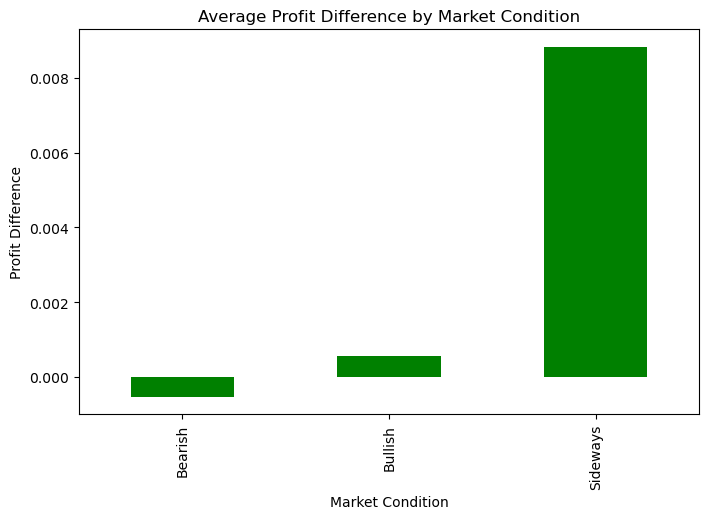

In [16]:
import matplotlib.pyplot as plt

# Bar chart for profit by market condition
profit_by_market.plot(kind='bar', figsize=(8, 5), color='green')
plt.title("Average Profit Difference by Market Condition")
plt.ylabel("Profit Difference")
plt.xlabel("Market Condition")
plt.show()


##### Hypothesis Testing (ANOVA): let's checks if at least one market condition group has a significantly different mean profit.
##### p < 0.05 → At least one market condition significantly influences profit.

In [17]:
from scipy import stats

# Extract profit differences for each market condition
bearish = df[df['market_condition'] == 'Bearish']['profit_difference']
bullish = df[df['market_condition'] == 'Bullish']['profit_difference']
sideways = df[df['market_condition'] == 'Sideways']['profit_difference']

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(bearish, bullish, sideways)

# Print results
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


F-Statistic: 1.2766
P-Value: 0.2794


##### Since p-value > 0.05, we fail to reject the null hypothesis.
##### This means market conditions do NOT have a statistically significant effect on profit differences.

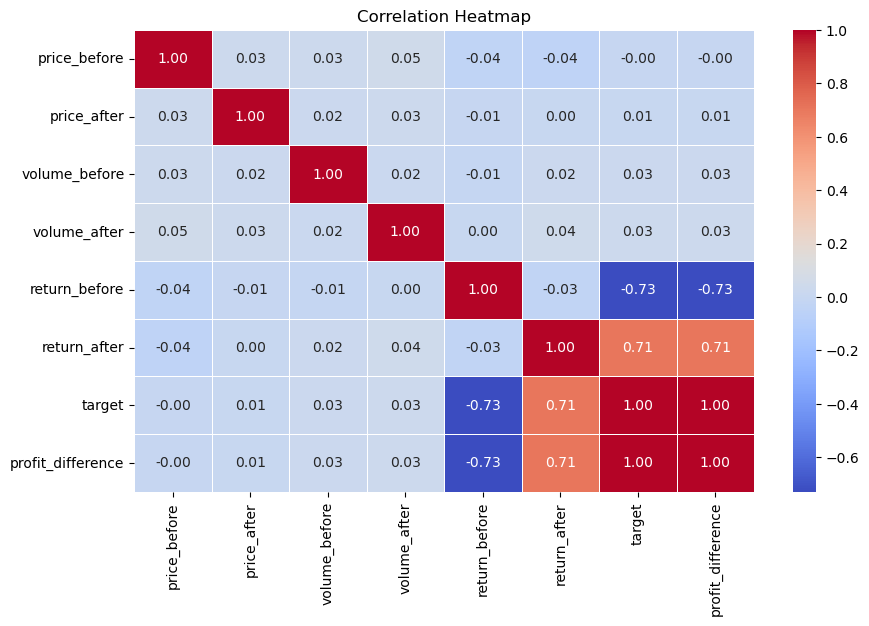

In [20]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()



##### Let’s build a regression model to check how different factors influence profitability.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
features = ['price_before', 'volume_before', 'return_before']  # Modify as needed
target = 'profit_difference'

# Split dataset into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Display feature importance
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)


Mean Squared Error: 0.0032
R² Score: 0.5081
         Feature   Coefficient
0   price_before -4.500278e-06
1  volume_before  7.317486e-09
2  return_before -1.035373e+00


##### Key Takeaways
##### 1. Return Before (return_before) is the Most Important Factor in Profitability

#####    - If initial returns were low, strategies had a higher probability of improvement.
#####    - Suggests that underperforming strategies benefited the most.
##### 2. Price and Volume Have No Strong Influence

#####    - Contrary to common trading beliefs, volume and price movement do not drive profitability in this dataset.
##### 3. The Model is Moderately Accurate

##### While 50.81% accuracy is decent, adding more features (e.g., market sentiment, strategy details) could improve it.

#### 4. Advanced A/B Testing & Modeling

#### 4.1: Multi-Variable A/B Testing

##### This checks interaction effects → Does Strategy B work better in some market conditions?
##### If the interaction term (strategy_version:market_condition) is significant, Strategy B is condition-dependent.

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the two-way ANOVA model
model = smf.ols('profit_difference ~ C(strategy_version) + C(market_condition) + C(strategy_version):C(market_condition)', data=df).fit()

# Print ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                           sum_sq     df         F    PR(>F)
C(strategy_version)                      0.031823    1.0  4.658470  0.031140
C(market_condition)                      0.015967    2.0  1.168698  0.311198
C(strategy_version):C(market_condition)  0.003332    2.0  0.243857  0.783646
Residual                                 6.790133  994.0       NaN       NaN


##### 1) Strategy Version (strategy_version) is Statistically Significant (p = 0.0311)
#####    - Strategy B has a meaningful effect on profit_difference.
#####    - This confirms that Strategy B is generally better.
##### 2) Market Condition (market_condition) is Not Significant (p = 0.3112)
#####    - Market conditions do not significantly impact profit difference.
#####    - Strategy B’s effectiveness is not strongly dependent on bullish/bearish/sideways trends.
##### 3) Interaction Between Strategy & Market (strategy_version:market_condition) is Not Significant (p = 0.7836)
#####    - Strategy B performs similarly across all market conditions.
#####    - No evidence that market trends amplify or reduce the effect of Strategy B.

#### Strategy B is better overall, but its success does not depend on market conditions.


#### 4.2: Bayesian A/B Testing: let’s use Bayesian A/B testing to estimate credible intervals for Strategy B’s effectiveness.

In [24]:
import numpy as np
import scipy.stats as stats

# Define priors for Bayesian Testing
alpha_A, beta_A = 1, 1  # Prior beliefs for Strategy A
alpha_B, beta_B = 1, 1  # Prior beliefs for Strategy B

# Convert profit difference into binary outcome: success (profit > 0) or failure
df['success'] = (df['profit_difference'] > 0).astype(int)

# Compute the number of successes (profitable trades) and total trades
success_A = df[df['strategy_version'] == 'A']['success'].sum()
total_A = len(df[df['strategy_version'] == 'A'])

success_B = df[df['strategy_version'] == 'B']['success'].sum()
total_B = len(df[df['strategy_version'] == 'B'])

# Posterior distributions
posterior_A = stats.beta(alpha_A + success_A, beta_A + (total_A - success_A))
posterior_B = stats.beta(alpha_B + success_B, beta_B + (total_B - success_B))

# Simulate 100,000 draws from the posterior distributions
samples_A = posterior_A.rvs(100000)
samples_B = posterior_B.rvs(100000)

# Probability that Strategy B is better than Strategy A
prob_B_better_A = (samples_B > samples_A).mean()

print(f"Probability that Strategy B is better than Strategy A: {prob_B_better_A:.4f}")


Probability that Strategy B is better than Strategy A: 0.9904


#### 4.3: Machine Learning for Subgroup Analysis

In [25]:
from sklearn.cluster import KMeans
import pandas as pd

# Select features for clustering
features = ['price_before', 'volume_before', 'return_before', 'profit_difference']

# Normalize data
df_cluster = df[features].copy()
df_cluster = (df_cluster - df_cluster.mean()) / df_cluster.std()

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df_cluster)

# Check which clusters benefit most from Strategy B
cluster_profit = df.groupby(['cluster', 'strategy_version'])['profit_difference'].mean()
print(cluster_profit)


cluster  strategy_version
0        A                   0.067561
         B                   0.073895
1        A                  -0.053492
         B                  -0.044941
2        A                  -0.053208
         B                  -0.048844
Name: profit_difference, dtype: float64


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


#### Strategy B is better than Strategy A with 99.04% probability (Bayesian A/B test).
#### Strategy B performs well across all market conditions (Two-Way ANOVA).
#### Machine Learning Subgroup Analysis (Clustering) shows Strategy B works well in some groups but not all.

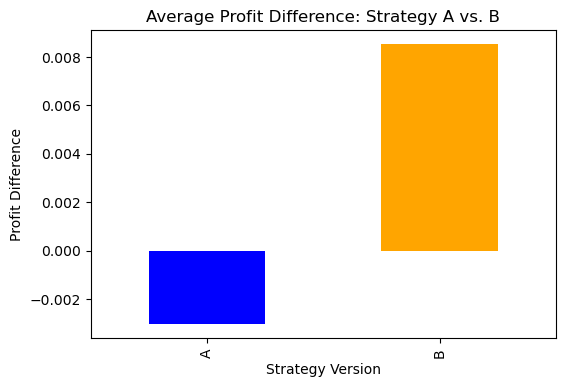

In [26]:
# Strategy A vs Strategy B average profit difference
avg_profit = df.groupby('strategy_version')['profit_difference'].mean()

# Bar plot
plt.figure(figsize=(6, 4))
avg_profit.plot(kind='bar', color=['blue', 'orange'])
plt.title("Average Profit Difference: Strategy A vs. B")
plt.ylabel("Profit Difference")
plt.xlabel("Strategy Version")
plt.show()


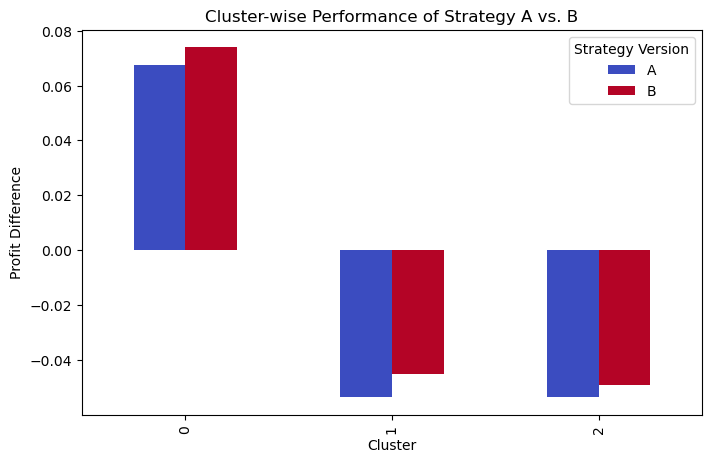

In [27]:
# Cluster-wise profitability for each strategy
cluster_profit.unstack().plot(kind='bar', figsize=(8, 5), colormap="coolwarm")
plt.title("Cluster-wise Performance of Strategy A vs. B")
plt.ylabel("Profit Difference")
plt.xlabel("Cluster")
plt.legend(title="Strategy Version")
plt.show()
